In [11]:
import hvplot.pandas # Enable 'hvplot' accessor on Geodataframes for interactive plotting
from ipywidgets import Layout
import h5py
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import leafmap.leafmap as leafmap
import geopandas as gpd
from ipyleaflet import Map, basemaps, ImageOverlay, projections, GeoJSON, GeoData, WMSLayer, Marker
import odc.geo.xr
import os

In [4]:
path = '/g/data/jk72/sc0554/floes/icesat/'
filelist = [file for file in os.listdir(path) if file.endswith('.h5')]

In [41]:
gf_list = []
print(f"Processing {len(filelist)} files")
for fname in filelist:
    print('\r', 'Opening:', fname, end='')
    for beam in ['gt1l','gt2l','gt3l','gt1r','gt2r','gt3r']:            
        # Open dataset
        ds = xr.open_dataset(path+fname, group=f'{beam}/freeboard_beam_segment/')
        # Convert to dataframe
        df = ds['beam_fb_height'].to_dataframe()
        # Create spatial dataframe
        gf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs='epsg:7661')
        # append to list
        gf_list.append(gf)

# Combine into a single file        
gfs = pd.concat(gf_list)

Processing 39 files
 Opening: ATL10-02_20211119110427_08861301_005_01.h5

<AxesSubplot:xlabel='latitude', ylabel='beam_fb_height'>

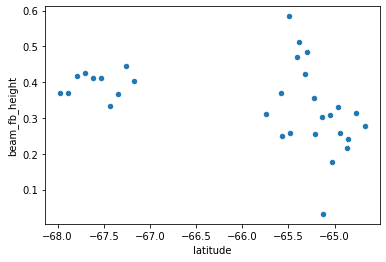

In [42]:
# Test plot

gf_list[0].plot.scatter('latitude', 'beam_fb_height')

In [ ]:
# Write out to csv (can be loaded as delimited text file into qgis

gfs.to_csv("/g/data/jk72/sc0554/floes/beam_fb_height.csv")

In [ ]:
from shapely.geometry import LineString
df['line'] = df.apply(lambda row: LineString([row['fr_point'], row['to_point']]), axis=1) #Create a linestring column

<AxesSubplot:xlabel='delta_time'>

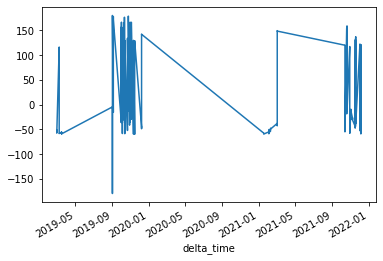

In [43]:
gfs['longitude'].plot()

In [64]:
filtered = gfs[(-60 < gfs.longitude) & (gfs.longitude < 0)]

In [65]:
geo_data = GeoData(geo_dataframe = filtered,
    style={'color': 'black', 'radius':4, 'fillColor': '#3366cc', 'opacity':0.5, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.6},
    hover_style={'fillColor': 'red' , 'fillOpacity': 0.2},
    point_style={'radius': 5, 'color': 'red', 'fillOpacity': 0.8, 'fillColor': 'blue', 'weight': 3},
    name = 'ICESAT2')

# Create custom projection with bounds for Polar view WMS layer
POLAR3031 = dict(
    name='EPSG:3031',
    custom=True,
    proj4def="""+proj=stere +lat_0=-90 +lat_ts=-71 +lon_0=0 +k=1
        +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs""",
    bounds =[[-2822131.5,-3057369.25],[3744213.75,3822194.25]]
)

graticule = WMSLayer(
    url='http://geos.polarview.aq/geoserver/wms',
    layers='polarview:graticuleS',
    format='image/png',
    transparent=True,
    attribution='Polarview',
    crs=POLAR3031
)

In [66]:
# Create map layer
spsLayout=Layout(width='800px', height='800px')
m = Map(basemap=basemaps.NASAGIBS.BlueMarble3031, center=(-90, 0), zoom=1, crs=projections.EPSG3031, layout=spsLayout)
m.add_layer(geo_data)
m.add_layer(graticule)
m

Map(center=[-90, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_tex…